# Notebook 4 – Predictions and visualization

Purpose:
- Load the latest trained model.
- Fetch weather forecast for at least the next day and build future features.
- Generate price predictions for the forecast horizon.
- Optionally write predictions to a `electricity_prices_predictions` feature group.
- Produce plots (hourly price forecast, forecast vs actual) and save them under `plots/` for the dashboard.

Notes:
- Document where plots are stored and naming conventions.
- Mention any steps needed when the model version changes.
- Indicate how often this notebook is expected to run.


In [1]:
from pathlib import Path
import os
import sys
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import json
import warnings
import holidays
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
import hopsworks

# 1. Find project root (one level up from notebooks/)
root_dir = Path("..").resolve()

# 2. Add project root to PYTHONPATH so we can import the src package
if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))

# 3. Load .env from project root
env_path = root_dir / ".env"
load_dotenv(env_path)

# 4. Load settings and utility functions (after adjusting PYTHONPATH)
from src.config import ElectricitySettings
from src import util

settings = ElectricitySettings()

# 5. Log in to Hopsworks and get feature store
project = hopsworks.login(engine="python")
fs = project.get_feature_store()


print("Successfully logged in to Hopsworks project:", settings.HOPSWORKS_PROJECT)


ElectricitySettings initialized
2025-12-16 19:22:03,516 INFO: Initializing external client
2025-12-16 19:22:03,516 INFO: Base URL: https://eu-west.cloud.hopsworks.ai:443
2025-12-16 19:22:04,867 INFO: Python Engine initialized.

Logged in to project, explore it here https://eu-west.cloud.hopsworks.ai:443/p/127
Successfully logged in to Hopsworks project: ScalableProject


In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
yesterday = today - datetime.timedelta(days = 1)


In [3]:
secrets = hopsworks.get_secrets_api()
area = secrets.get_secret("ELECTRICITY_LOCATION_JSON").value
area = json.loads(area)
PRICE_AREA = area['price_area']
CITY = area['city']
LATITUDE = area['latitude']
LONGITUDE = area['longitude']

In [4]:
mr = project.get_model_registry()

# Load exact per-sensor model for this slug (no fallback)
model_name = f"electricity_prices_xgboost_model_lags_{PRICE_AREA.lower()}"
retrieved_model = mr.get_model(name=model_name)
if retrieved_model is None:
    raise RuntimeError(f"Model '{model_name}' not found in registry")

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-12-16 19:22:05,862 WARNING: VersionWarning: No version provided for getting model `electricity_prices_xgboost_model_lags_se3`, defaulting to `1`.



Downloading: 0.000%|          | 0/5335463 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/115919 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/115919 elapsed<00:00 remaining<?

In [5]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='6.099053E-1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['int', 'int', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'int', 'in...
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [6]:
# --- Fetch historical prices (last 4 days) to build lag features ---
electricity_prices_fg = fs.get_feature_group('electricity_prices', version=1)
lookback_start = (pd.Timestamp.utcnow() - pd.Timedelta(days=4)).normalize()

hist_prices = electricity_prices_fg.filter(
    (electricity_prices_fg.price_area == PRICE_AREA.lower()) &
    (electricity_prices_fg.date >= lookback_start)
).read()

hist_prices['date'] = pd.to_datetime(hist_prices['date'], utc=True)
hist_prices = hist_prices.sort_values('unix_time')[['price_area','date','hour','unix_time','price_sek']]

# --- Fetch weather forecast for kommande dagar ---
forecast_days = 2  
forecast_df = util.get_hourly_weather_forecast(
    latitude=LATITUDE,
    longitude=LONGITUDE,
    city=PRICE_AREA.lower(),
    forecast_days=forecast_days,
)
forecast_df['date'] = pd.to_datetime(forecast_df['timestamp'], utc=True)
forecast_df['unix_time'] = forecast_df['date'].astype('int64') // 10**6
forecast_df['price_area'] = PRICE_AREA.lower()
forecast_df['price_area'] = forecast_df['price_area'].astype('string')
if 'city' in forecast_df.columns:
    forecast_df = forecast_df.drop(columns=['city'])
forecast_df = forecast_df.drop(columns=['timestamp'])

# Behåll bara imorgon
forecast_day = (pd.Timestamp.utcnow().normalize() + pd.Timedelta(days=1)).date()
forecast_df = forecast_df[forecast_df['date'].dt.date == forecast_day].copy()

# Kalender/helg/season/holiday
forecast_df['weekday'] = forecast_df['date'].dt.weekday.astype('int8')
forecast_df['is_weekend'] = forecast_df['weekday'].isin([5, 6]).astype('int8')
forecast_df['month'] = forecast_df['date'].dt.month.astype('int8')
season_map = {12: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 3, 10: 3, 11: 3}
forecast_df['season'] = forecast_df['month'].map(season_map).astype('int8')
try:
    years = range(forecast_df['date'].dt.year.min(), forecast_df['date'].dt.year.max() + 1)
    se_holidays = holidays.Sweden(years=years)
    forecast_df['is_holiday'] = forecast_df['date'].dt.date.isin(se_holidays).astype('int8')
except Exception:
    forecast_df['is_holiday'] = 0

# --- Bygg lag features genom att kombinera historik + forecast-platshållare ---
forecast_prices = forecast_df[['price_area','date','hour','unix_time']].copy()
forecast_prices['price_sek'] = np.nan

lag_base = pd.concat([
    hist_prices[['price_area','date','hour','unix_time','price_sek']],
    forecast_prices
], ignore_index=True).sort_values('unix_time')

for lag in [24, 48, 72]:
    lag_base[f'price_lag_{lag}'] = lag_base.groupby('price_area')['price_sek'].shift(lag).astype('float32')

lag_base['price_roll3d'] = (
    lag_base.groupby('price_area')['price_sek']
            .rolling(72, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
            .astype('float32')
)

# Plocka ut lag-features för forecast-rader
lags_forecast = lag_base[lag_base['price_sek'].isna()][['unix_time','price_lag_24','price_lag_48','price_lag_72','price_roll3d']]
forecast_df = forecast_df.merge(lags_forecast, on='unix_time', how='left')

# --- Förbered feature-matris för inferens ---
# Matcha träningsnamn: price-features är prefixade av Hopsworks (electricity_prices_*)
forecast_df = forecast_df.copy()
forecast_df['electricity_prices_unix_time'] = forecast_df['unix_time']
forecast_df['electricity_prices_weekday'] = forecast_df['weekday']
forecast_df['electricity_prices_is_weekend'] = forecast_df['is_weekend']
forecast_df['electricity_prices_month'] = forecast_df['month']
forecast_df['electricity_prices_season'] = forecast_df['season']
forecast_df['electricity_prices_is_holiday'] = forecast_df['is_holiday']
forecast_df['electricity_prices_price_lag_24'] = forecast_df['price_lag_24']
forecast_df['electricity_prices_price_lag_48'] = forecast_df['price_lag_48']
forecast_df['electricity_prices_price_lag_72'] = forecast_df['price_lag_72']
forecast_df['electricity_prices_price_roll3d'] = forecast_df['price_roll3d']

feature_cols = [
    "price_area",
    "unix_time",
    "date",
    "hour",
    "temperature_2m", "apparent_temperature",
    "precipitation", "rain", "snowfall",
    "cloud_cover",
    "wind_speed_10m", "wind_speed_100m",
    "wind_direction_10m", "wind_direction_100m",
    "wind_gusts_10m",
    "surface_pressure",
    # prefixed price cols expected by model
    "electricity_prices_unix_time",
    "electricity_prices_weekday",
    "electricity_prices_is_weekend",
    "electricity_prices_month",
    "electricity_prices_season",
    "electricity_prices_is_holiday",
    "electricity_prices_price_lag_24",
    "electricity_prices_price_lag_48",
    "electricity_prices_price_lag_72",
    "electricity_prices_price_roll3d",
]
forecast_df = forecast_df[feature_cols]

cat_cols = [c for c in forecast_df.columns if 'price_area' in c]
X_pred = forecast_df.drop(columns=['date'] + cat_cols)

# --- Prediktera ---
predictions = retrieved_xgboost_model.predict(X_pred)
forecast_df['predicted_price_sek'] = predictions.astype('float32')

# Visa resultat för imorgon
print(forecast_df[['date','hour','predicted_price_sek']].sort_values(['date','hour']).head(24))


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.62s) 
Fetching weather forecast for se3 (59.3251, 18.0711)...
Coordinates: 59.32889938354492°N 18.072357177734375°E
Elevation: 23.0 m asl
Fetched 48 hourly forecast records
                        date  hour  predicted_price_sek
0  2025-12-17 00:00:00+00:00     0             0.391029
1  2025-12-17 01:00:00+00:00     1             0.392746
2  2025-12-17 02:00:00+00:00     2             0.377302
3  2025-12-17 03:00:00+00:00     3             0.351548
4  2025-12-17 04:00:00+00:00     4             0.256396
5  2025-12-17 05:00:00+00:00     5             0.381731
6  2025-12-17 06:00:00+00:00     6             0.451806
7  2025-12-17 07:00:00+00:00     7             0.519578
8  2025-12-17 08:00:00+00:00     8             0.567788
9  2025-12-17 09:00:00+00:00     9             0.547187
10 2025-12-17 10:00:00+00:00    10             0.396905
11 2025-12-17 11:00:00+00:00    11             0.404868
12 2025-12-17 12:00

In [10]:
import reload

In [11]:
import importlib
import src.util as util
importlib.reload(util)

<module 'src.util' from '/Users/jesper/Documents/KTH/Skalbar_ML/Project/src/util.py'>

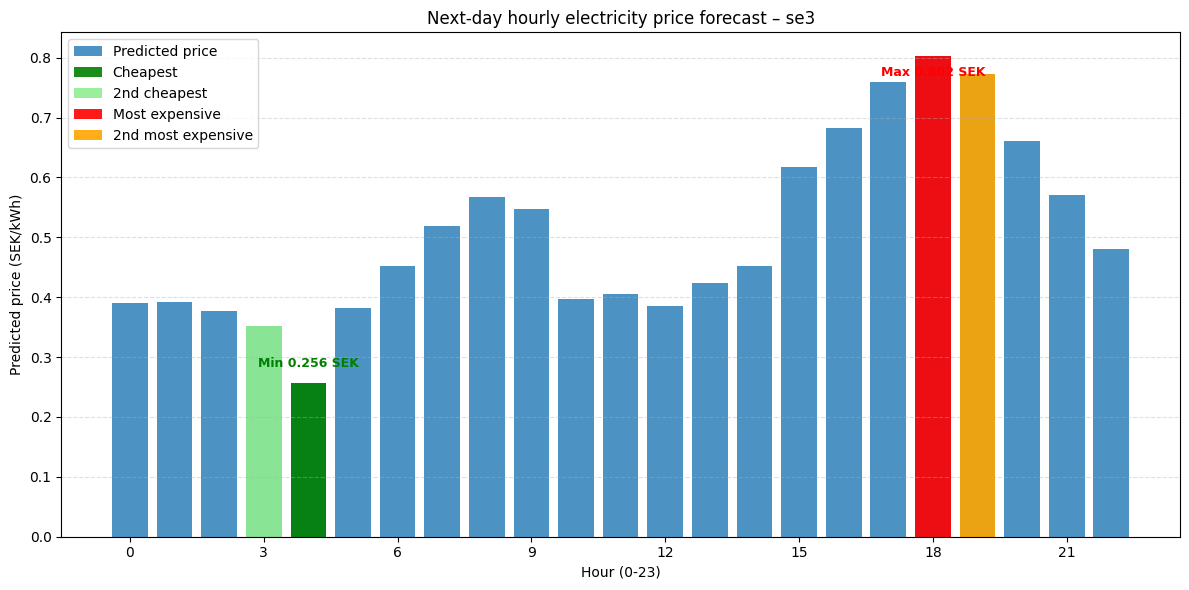

In [ ]:
file_path = f"{root_dir}/docs/PricesDashboard/assets/img/electricity_price_forecast_se3.png"

util.plot_next_day_price_forecast(forecast_df, PRICE_AREA.lower(), file_path=file_path)
plt.show()



In [14]:
# Upload plot to Hopsworks Resources (optional)
dataset_api = project.get_dataset_api()
str_today = pd.Timestamp.utcnow().strftime("%Y-%m-%d")
if not dataset_api.exists("Resources/electricity_prices"):
    dataset_api.mkdir("Resources/electricity_prices")
dataset_api.upload(file_path, f"Resources/electricity_prices/electricity_price_forecast_se3_{str_today}.png", overwrite=True)
proj_url = project.get_url()
print(f"Plot uploaded to: {proj_url}/settings/fb/path/Resources/electricity_prices")

Uploading /Users/jesper/Documents/KTH/Skalbar_ML/Project/docs/PricesDashboard/assets/img/electricity_price_for…

Plot uploaded to: https://eu-west.cloud.hopsworks.ai:443/p/127/settings/fb/path/Resources/electricity_prices
